# Small molecule similarity between datasets

In [1]:
import os
import pandas as pd
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from itertools import combinations

In [3]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-27/12-00-04"
run_dirs = [f"{INPUT_DIR}/{run_dir}" for run_dir in os.listdir(INPUT_DIR) if run_dir != "multirun.yaml"]
assay_dirs = [f"{run_dir}/data/processed/assay" for run_dir in run_dirs]
feature_dirs = [f"{run_dir}/data/processed/feature" for run_dir in run_dirs]

dfs = []

bit_cols = [f"bit_{i}" for i in range(1024)]
bit_col_string = ", ".join(bit_cols)

for run in zip(assay_dirs, feature_dirs):
    # Read in all assay data from a given folder
    con = duckdb.connect()
    query = f"""
    SELECT a.canonical_smiles AS canonical_smiles, source_id, {bit_col_string}
    FROM read_parquet('{run[0]}/*.parquet') AS a
    JOIN read_parquet('{run[1]}/*.parquet') AS b
    ON a.canonical_smiles = b.canonical_smiles
    """
    df = con.execute(query).df()
    dfs.append(df)

# Join constituent dataframes together
df = pd.concat(dfs)

In [4]:
# Get unique datasets
datasets = df["source_id"].unique()

df.reset_index(drop=True, inplace=True)

In [5]:
datasets

array(['cancerrx', 'nci60', 'meic', 'toxcast', 'prism',
       'acute_oral_toxicity', 'toxval'], dtype=object)

In [6]:
SAMPLE_SIZE = 50

# Get unique combination of dataset pairs
pairs = list(combinations(datasets, 2))

# Prepare dataframe to store outcomes
outcomes = pd.DataFrame(columns=['dataset1', 'dataset2', 'median_hamming_distance'])

for pair in pairs:
    df1 = df[df["source_id"] == pair[0]].sample(SAMPLE_SIZE)
    df2 = df[df["source_id"] == pair[1]].sample(SAMPLE_SIZE)

    hamming_distances = []

    for i in range(SAMPLE_SIZE):
        # Calculate hamming distance between row i of each dataframe
        distance = hamming(df1.iloc[i].tolist(), df2.iloc[i].tolist())
        hamming_distances.append(distance)

    median_distance = np.median(hamming_distances)
    
    outcomes = pd.concat([outcomes, pd.DataFrame([{'dataset1': pair[0], 'dataset2': pair[1], 'median_hamming_distance': median_distance}])], ignore_index=True)

In [7]:
print(len(pairs))

21


In [8]:
outcomes

,dataset1,dataset2,median_hamming_distance
0,cancerrx,nci60,0.074074
1,cancerrx,meic,0.069688
2,cancerrx,toxcast,0.072125
3,cancerrx,prism,0.081871
4,cancerrx,acute_oral_toxicity,0.069201
5,cancerrx,toxval,0.067739
6,nci60,meic,0.058480
7,nci60,toxcast,0.061404
8,nci60,prism,0.070175
9,nci60,acute_oral_toxicity,0.057018


I will now view this as a heatmap.

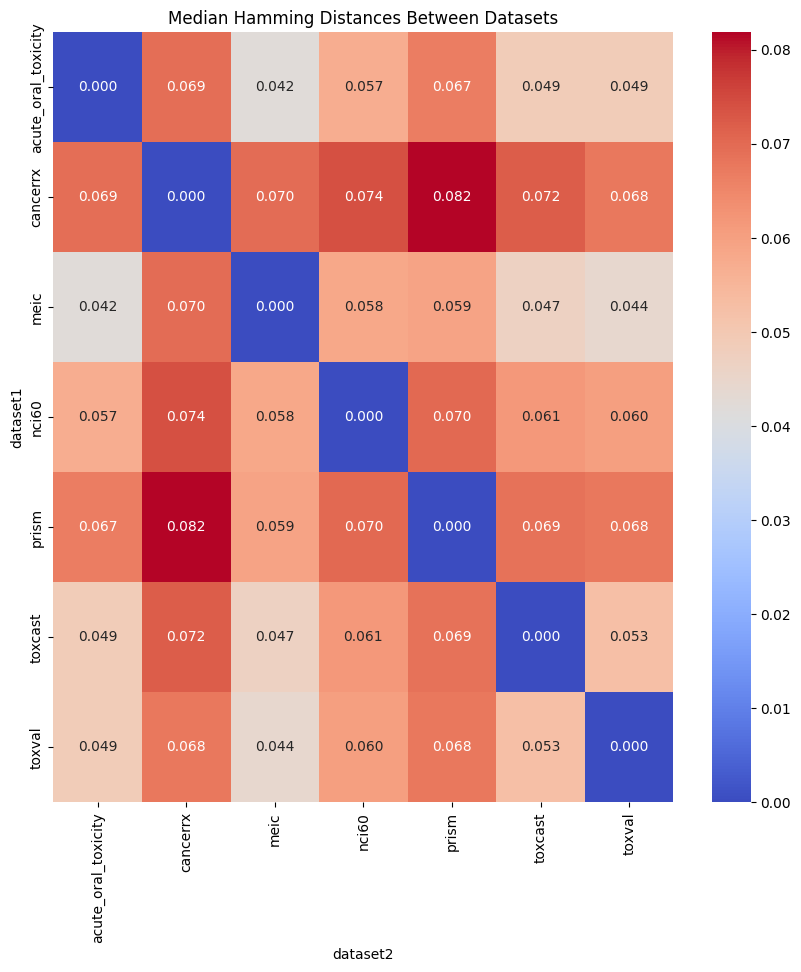

In [9]:
# Mirror the outcomes dataframe to ensure symmetry
outcomes_mirror = outcomes.copy()
outcomes_mirror.rename(columns={'dataset1':'dataset2', 'dataset2':'dataset1'}, inplace=True)

# Append the mirrored dataframe to the original dataframe
outcomes_sym = pd.concat([outcomes, outcomes_mirror], ignore_index=True)

# Pivot the symmetric dataframe to create a matrix
matrix_sym = outcomes_sym.pivot(index='dataset1', columns='dataset2', values='median_hamming_distance')

# Fill the diagonal of the matrix
np.fill_diagonal(matrix_sym.values, 0)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_sym, annot=True, fmt=".3f", cmap='coolwarm')

# Display the plot
plt.title('Median Hamming Distances Between Datasets')
plt.show()

# Stability of subsample

I want to check whether the hamming distance continues changing beyond a sample size of 50.

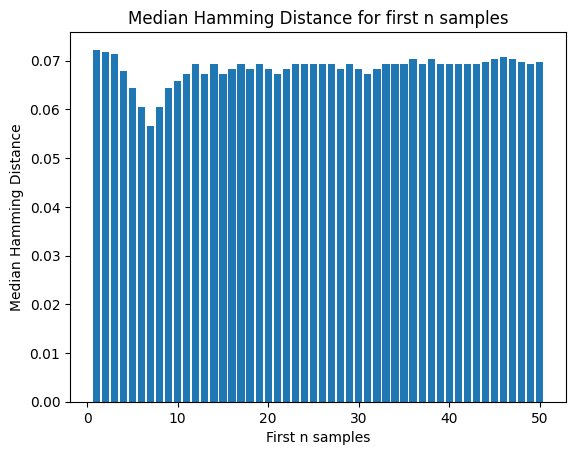

In [97]:
# Plotting
plt.bar(range(1, SAMPLE_SIZE+1), medians)
plt.xlabel('First n samples')
plt.ylabel('Median Hamming Distance')
plt.title('Median Hamming Distance for first n samples')
plt.show()

In [ ]:
dd# Plot a barplot where y-axis is median hamming distance, and x-axis is first-n-samples

In [66]:
hamming_distance = hamming("str", "str")
print(hamming_distance)

ValueError: Input vector should be 1-D.